In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np


# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Only look at 3s and 8s
train_picks = np.logical_or(y_train==2,y_train==7)
test_picks = np.logical_or(y_test==2,y_test==7)

x_train = x_train[train_picks]
x_test = x_test[test_picks]
y_train = np.array(y_train[train_picks]==7,dtype=int)
y_test = np.array(y_test[test_picks]==7,dtype=int)


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


Using TensorFlow backend.


x_train shape: (12223, 28, 28, 1)
12223 train samples
2060 test samples


In [2]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.optimizers import SGD

# def make_model( ):    
def make_model(learn_rate=0.1, momentum=0):
    
    
    dense_layer_sizes = [64]
    pool_size = (2, 2)
    filters = 8
    kernel_size = (3, 3)
    
    model = Sequential()
    model.add(Conv2D(4, kernel_size,activation='relu',input_shape=input_shape))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])    
    
    return model


In [3]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
# from sklearn.grid_search import GridSearchCV

batch_size = [10, 50, 100, 150, 200, 250]
# epochs = [10, 50, 100]

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# param_grid = dict(batch_size=batch_size, optimizer=optimizer)
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
# param_grid = dict(batch_size=batch_size, epochs=epochs)

my_classifier = KerasClassifier(make_model, epochs=12, batch_size=128, verbose=0)
grid = GridSearchCV(my_classifier,param_grid=param_grid, n_jobs=1)

In [4]:
grid_result=grid.fit(x_train, y_train)

In [5]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.993210 using {'learn_rate': 0.2, 'momentum': 0.8}
0.954348 (0.019457) with: {'learn_rate': 0.001, 'momentum': 0.0}
0.966866 (0.002830) with: {'learn_rate': 0.001, 'momentum': 0.2}
0.963021 (0.006026) with: {'learn_rate': 0.001, 'momentum': 0.4}
0.971038 (0.004540) with: {'learn_rate': 0.001, 'momentum': 0.6}
0.978156 (0.001405) with: {'learn_rate': 0.001, 'momentum': 0.8}
0.981101 (0.001913) with: {'learn_rate': 0.001, 'momentum': 0.9}
0.982574 (0.001914) with: {'learn_rate': 0.01, 'momentum': 0.0}
0.982737 (0.001226) with: {'learn_rate': 0.01, 'momentum': 0.2}
0.984128 (0.001451) with: {'learn_rate': 0.01, 'momentum': 0.4}
0.984946 (0.000811) with: {'learn_rate': 0.01, 'momentum': 0.6}
0.987728 (0.001314) with: {'learn_rate': 0.01, 'momentum': 0.8}
0.990673 (0.001203) with: {'learn_rate': 0.01, 'momentum': 0.9}
0.989364 (0.000760) with: {'learn_rate': 0.1, 'momentum': 0.0}
0.990346 (0.000760) with: {'learn_rate': 0.1, 'momentum': 0.2}
0.990673 (0.001253) with: {'learn_rate': 0

/usr/local/lib/python3.4/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


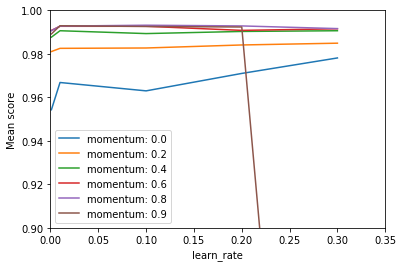

In [14]:
import matplotlib.pyplot as plt

Gammas = learn_rate
Cs = momentum

scores = [x[1] for x in grid_result.grid_scores_]
scores = np.array(scores).reshape(len(Cs), len(Gammas))

for ind, i in enumerate(Cs):
    plt.plot(Gammas, scores[ind], label='momentum: ' + str(i))
plt.legend()
plt.xlabel('learn_rate')
plt.ylabel('Mean score')
plt.axis([0, 0.35, 0.9, 1])
plt.show()

In [ ]:
grid_result.grid_scores_

/usr/local/lib/python3.4/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


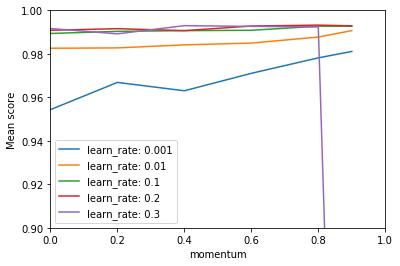

In [12]:
Gammas = momentum
Cs = learn_rate

scores = [x[1] for x in grid_result.grid_scores_]
scores = np.array(scores).reshape(len(Cs), len(Gammas))

for ind, i in enumerate(Cs):
    plt.plot(Gammas, scores[ind], label='learn_rate: ' + str(i))
plt.legend()
plt.xlabel('momentum')
plt.ylabel('Mean score')
plt.axis([0, 1, 0.9, 1])
plt.show()

In [11]:

print('The parameters of the best model are: ')
print(grid_result.best_params_)

# validator.best_estimator_ returns sklearn-wrapped version of best model.
# validator.best_estimator_.model returns the (unwrapped) keras model
best_model = grid_result.best_estimator_.model
metric_names = best_model.metrics_names
metric_values = best_model.evaluate(x_test, y_test)
for metric, value in zip(metric_names, metric_values):
    print(metric, ': ', value)

The parameters of the best model are: 
{'learn_rate': 0.2, 'momentum': 0.8}
1408/2060 [===================>..........] - ETA: 0sloss :  0.0245782235146
acc :  0.991747572816


The parameters of the best model are: 
{'learn_rate': 0.2, 'momentum': 0.8}
1408/2060 [===================>..........] - ETA: 0sloss :  0.0245782235146
acc :  0.991747572816